POSIBLES SOLUCIONES AL PROBLEMA:

- ELIMINAR LOS OUTLIERS Y STANDARIZAR LOS DATOS CLASIFICAR LOS OUTLIERS COMO POSITIVOS O NEGATIVOS PARA EL CUESTIONARIO FINAL
OJO LAS VARIABLES FORMAT FILL RATE Y OTROS %, VER SI SE QUITAN

- PARA EL CUESTIONARIO FINAL, DEFINIR RANGOS DE LAS VARIABLES DE UN CLUSTER, POR EJEMPLO, CPM CLUSTER 1 ENTRE 1 Y 3, PARA RECOMENDAR UNO U OTRO

- TRANSFORMACIÓN LOGARITIMICA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pickle
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import calinski_harabasz_score


pd.options.display.float_format = '{:.2f}'.format #So the numbers will not appear in a scientific format

# !pip install pyclustertend
# !pip install kmodes
# !pip install gower
# !pip install prince

In [4]:
groupby_domains = pd.read_csv('Global groupby_domains.csv')
report = pd.read_csv("Global Report.csv", index_col=['Time'])

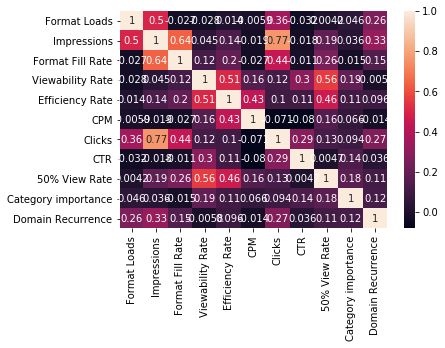

In [6]:
sns.heatmap(groupby_domains.corr(), annot=True)

In [5]:
groupby_domains= groupby_domains.drop(['Domain', 'Format Fill Rate', 'Viewability Rate', 'Efficiency Rate',  'Category'], 1)


In [6]:
robust = RobustScaler().fit_transform(groupby_domains)
pca_2_robust = pd.DataFrame(PCA(n_components = 2).fit_transform(robust))
standardscaler = StandardScaler().fit_transform(groupby_domains)
minmax = MinMaxScaler().fit_transform(groupby_domains)
pca_2_groupby_domains = pd.DataFrame(PCA(n_components = 2).fit_transform(groupby_domains))


reducing3f = groupby_domains[['Impressions', 'Format Loads', 'Clicks']]
reducing3f = PCA(n_components=1).fit_transform(reducing3f)
reducing3f_ = groupby_domains.copy()
reducing3f_['PCA:FL,Impressions,Clicks'] = reducing3f
reducing3f_.drop(['Impressions', 'Format Loads', 'Clicks'], 1, inplace=True)

In [130]:
pd.DataFrame(reducing3f_).describe()

,CPM,CTR,50% View Rate,Category importance,Domain Recurrence,"PCA:FL,Impressions,Clicks"
count,818.00,818.00,818.00,818.00,818.00,818.00
mean,1.69,0.69,72.86,0.34,0.72,0.00
std,0.25,0.53,11.57,0.27,0.99,215466.64
min,0.00,0.00,0.00,0.00,0.00,-120004.16
25%,1.59,0.32,68.39,0.05,0.00,-98877.25
50%,1.67,0.61,75.06,0.59,0.00,-70806.43
75%,1.76,0.93,79.90,0.59,1.00,6561.17
max,3.55,4.68,100.00,0.59,3.00,2653860.28


## DETECTING OUTLIERS

In [85]:
Q1 = groupby_domains.quantile(0.25)
Q3 = groupby_domains.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Format Loads          105514.49
Impressions            15362.78
CPM                        0.17
Clicks                   107.11
CTR                        0.61
50% View Rate             11.51
Category importance        0.54
Domain Recurrence          1.00
dtype: float64


In [100]:
no_outliers = groupby_domains[~((groupby_domains< (Q1 - 1.5 * IQR)) |(groupby_domains> (Q3 + 1.5 * IQR)))]
no_outliers.dropna(inplace=True)
no_outliers['Outlier']=0

In [119]:
outliers = groupby_domains.merge(no_outliers,how='left').fillna(value=1)
outliers = outliers[outliers['Outlier']==1]
outliers.drop('Outlier',1,inplace=True)
no_outliers.drop('Outlier',1,inplace=True)

In [8]:
#from sklearn import manifold
#from sklearn.metrics import euclidean_distances

#similarities = euclidean_distances(groupby_domains)

#mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)

#pos = mds.fit(similarities).embedding_

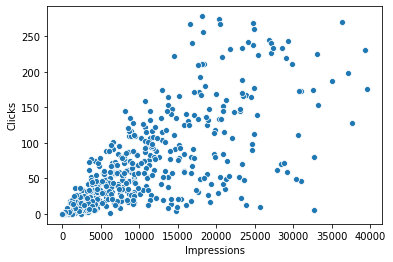

In [132]:
sns.scatterplot(no_outliers['Impressions'], no_outliers['Clicks'])

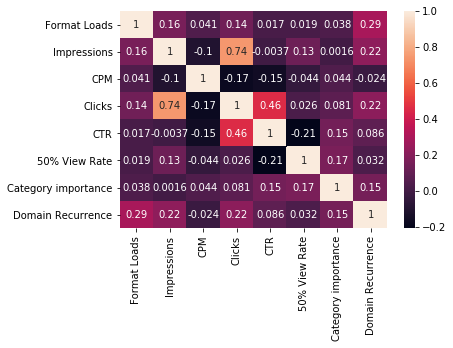

In [125]:
sns.heatmap(no_outliers.corr(), annot=True)

In [153]:
new_variable.shape

(563, 1)

In [188]:
pca=PCA(n_components=1)
new_variable = pca.fit_transform(no_outliers[['Impressions','Clicks']])
print(pca.explained_variance_ratio_)
no_outliers_modified = no_outliers.copy()
no_outliers_modified['PCA: Impressions/Clicks'] = new_variable
no_outliers_modified.drop(['Impressions', 'Clicks'], 1, inplace=True)

[0.9999749]


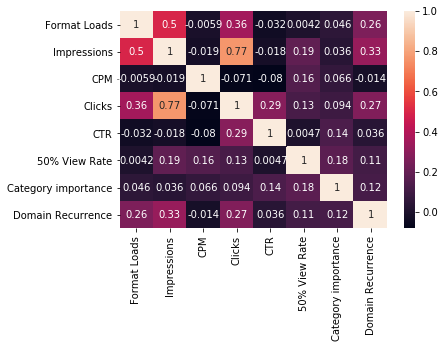

In [126]:
sns.heatmap(groupby_domains.corr(), annot=True)

## KPrototypes

In [8]:
from kmodes.kprototypes import KPrototypes

In [9]:
groupby_domains.head(1)

,Format Loads,Impressions,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
0,2849893.77,9517.08,1.58,48.92,0.49,66.98,0.02,1


<function matplotlib.pyplot.show(*args, **kw)>

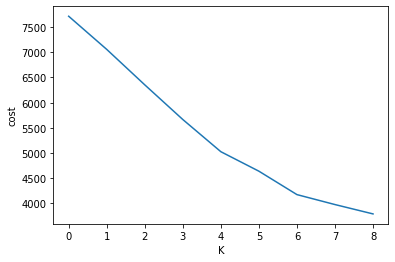

In [12]:
#Choosing optimal K value
cost = []
for num_clusters in list(range(3,12)):
    kproto = KPrototypes(n_clusters=num_clusters) 
    kproto.fit_predict(robust, categorical=[6,7])
    cost.append(kproto.cost_)

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [17]:
k_pro = KPrototypes(n_clusters=6)
k_pro.fit(robust, categorical = [6,7])


KPrototypes(cat_dissim=<function matching_dissim at 0x000001DE8FF56318>,
            gamma=0.7887883308824392, init='Huang', max_iter=100, n_clusters=6,
            n_init=10, n_jobs=1,
            num_dissim=<function euclidean_dissim at 0x000001DE8FF56A68>,
            random_state=None, verbose=0)

In [18]:
pd.DataFrame(k_pro.labels_)[0].value_counts()

0    585
2    118
3     47
4     45
1     13
5     10
Name: 0, dtype: int64

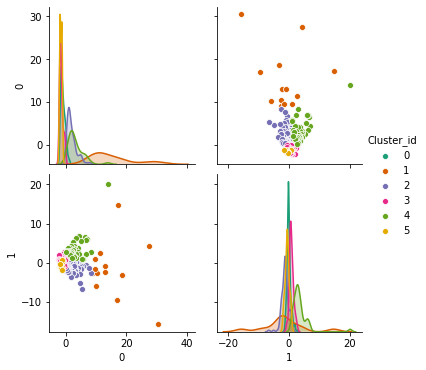

In [19]:
groupby_domains_kprototypes = pd.DataFrame(pca_2_robust)
groupby_domains_kprototypes['Cluster_id']=k_pro.labels_
sns.pairplot(groupby_domains_kprototypes,hue='Cluster_id',palette='Dark2',diag_kind='kde')

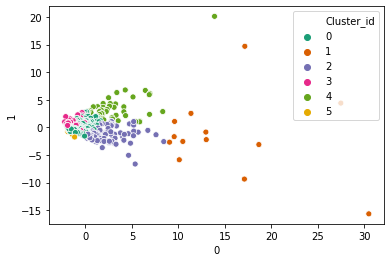

In [23]:
sns.scatterplot(groupby_domains_kprototypes[0], groupby_domains_kprototypes[1], hue = groupby_domains_kprototypes['Cluster_id'], palette='Dark2')

In [24]:
print('The Silhouette Score is:', silhouette_score(robust, k_pro.labels_))
print('The Calinski Harabasz Score is:', calinski_harabasz_score(robust, k_pro.labels_))

The Silhouette Score is: 0.3045945135858173
The Calinski Harabasz Score is: 176.55445241902606


## GAUSSIAN MIXTURE MODELS 

https://scikit-learn.org/stable/modules/mixture.html

It is not necessary to scale the data, so I´m gonna test the algorithm with the 3 data transformation that are not standarized:
    
- reducing3f_
- groupby_domains
- pca_2_groupby_domains

In [52]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture


## Number of components(k) selection: 

### Silhouette score

Silhouette score checks how much the clusters are compact and well separated. The more the score is near to one, the better the clustering is. Read more here

Since we already know that the fitting procedure is not deterministic, we run twenty fits for each number of clusters, then we consider the mean value and the standard deviation of the best five runs.

Text(0, 0.5, 'Score')

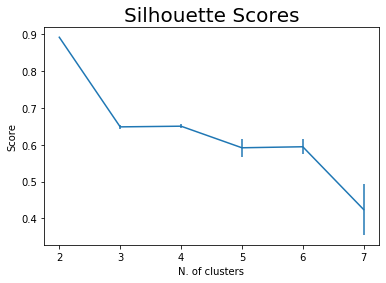

In [140]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

n_clusters=np.arange(2, 8)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(pca_log) 
        labels=gmm.predict(pca_log)
        sil=silhouette_score(pca_log, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)
    
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

### Distance between GMMs

Here we form two datasets, each with an half randomly choose amount of data. We will then check how much the GMMs trained on the two sets are similar, for each configuration.

Since we are talking about distributions, the concept of similarity is embedded in the Jensen-Shannon (JS) metric. The lesser is the JS-distance between the two GMMs, the more the GMMs agree on how to fit the data.

The lower the distance, the better the cluster.

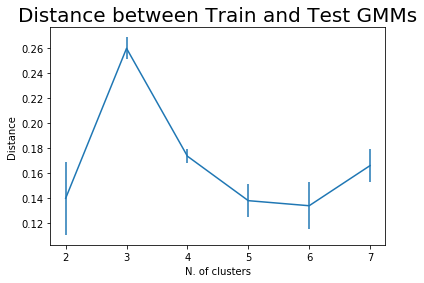

In [55]:
from sklearn.model_selection import train_test_split

def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

n_clusters=np.arange(2, 8)
iterations=20
results=[]
res_sigs=[]
for n in n_clusters:
    dist=[]
    
    for iteration in range(iterations):
        train, test=train_test_split(pca_log, test_size=0.5)
        
        gmm_train=GaussianMixture(n, n_init=2, reg_covar = 1e-03).fit(train) 
        gmm_test=GaussianMixture(n, n_init=2, reg_covar = 1e-03).fit(test) 
        dist.append(gmm_js(gmm_train, gmm_test))
    selec=SelBest(np.array(dist), int(iterations/5))
    result=np.mean(selec)
    res_sig=np.std(selec)
    results.append(result)
    res_sigs.append(res_sig)
    
plt.errorbar(n_clusters, results, yerr=res_sigs)
plt.title("Distance between Train and Test GMMs", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Distance")
plt.show()

### Bayesian information criterion (BIC): 

This criterion gives us an estimation on how much is good the GMM in terms of predicting the data we actually have. The lower is the BIC, the better is the model to actually predict the data we have. In order to avoid overfitting, this technique penalizes models with big number of clusters.




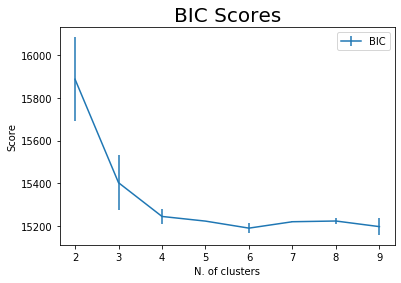

In [57]:
n_clusters=np.arange(2, 10)
bics=[]
bics_err=[]
iterations=20
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2, reg_covar = 1e-06).fit(pca_log) 
        
        tmp_bic.append(gmm.bic(pca_log))
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)
    
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

Following this criterion, the bigger the number of clusters, the better should be the model. Which means that the penalty BIC criteria gives to complex models do not save us from overfit.

But before screaming and trashing out this technique, we can notice two things. The first is that the curve is fairly smooth and monotone. The second is that the curve follows different slopes in different part of it. Starting from these two observations, the temptation to check where the BIC curve change slope is big. So let’s check it!

Technically, we have to calculate the gradient of the BIC scores curve. Intuitively, the concept of gradient is simple: if two consecutive points have the same value, their gradient is zero. If they have different values, their gradient can be eighter negative, if the second point has a lower value, or positive otherwise. The magnitude of the gradient tells us how much the two values are different.


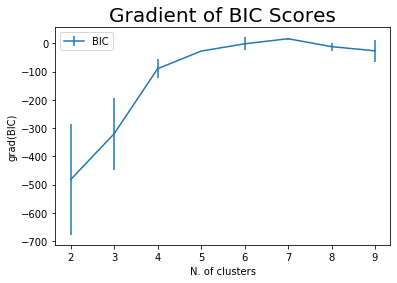

In [58]:
plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

Automatically created module for IPython interactive environment


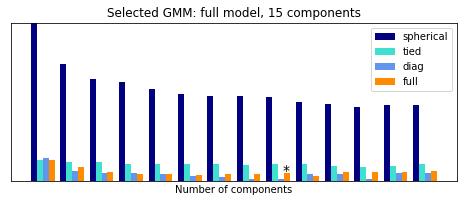

In [65]:
import itertools

from scipy import linalg
import matplotlib as mpl

from sklearn import mixture

print(__doc__)

# Number of samples per component
n_samples = 818

lowest_bic = np.infty
bic = []
n_components_range = range(1, 15)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type, reg_covar = 1e-03)
        gmm.fit(groupby_domains_log)
        bic.append(gmm.bic(groupby_domains_log))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)


plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 15 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [66]:
gm = GaussianMixture(n_components=9, covariance_type= 'spherical', max_iter=200, n_init=53  )
pd.DataFrame(gm.fit_predict(groupby_domains_log))[0].value_counts()

3    339
8    140
0    116
6    103
7     60
2     32
5     19
1      5
4      1
Name: 0, dtype: int64

In [75]:
groupby_domains_log

,Format Loads,Impressions,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence,Cluster
0,14.86,9.16,1.58,48.92,0.49,66.98,0.02,1,0.00
1,14.70,11.94,1.71,125.82,0.08,60.76,0.59,1,3.00
2,14.58,12.62,1.62,1278.98,0.44,87.12,0.59,1,1.00
3,13.99,10.55,1.50,162.41,0.40,70.75,0.08,0,3.00
4,13.97,10.52,1.62,241.97,1.06,75.06,0.07,1,7.00
...,...,...,...,...,...,...,...,...,...
810,11.19,6.60,1.62,21.00,2.86,57.63,0.04,0,0.00
811,11.19,4.44,1.67,0.00,0.00,60.00,0.59,0,6.00
812,11.18,2.08,1.52,0.00,0.00,87.50,0.59,0,nan
813,11.18,8.25,1.88,45.00,1.17,61.83,0.00,0,nan


In [69]:
gm.fit_predict(groupby_domains_log)

array([0, 4, 1, 4, 2, 1, 7, 0, 1, 4, 0, 6, 1, 3, 1, 1, 7, 5, 4, 4, 8, 4,
       2, 0, 5, 5, 7, 0, 2, 6, 7, 8, 2, 8, 8, 7, 8, 1, 0, 4, 8, 6, 2, 1,
       6, 1, 6, 4, 8, 7, 4, 7, 4, 7, 5, 6, 8, 4, 5, 8, 5, 7, 2, 2, 6, 4,
       4, 7, 7, 6, 8, 0, 0, 0, 7, 2, 4, 4, 4, 7, 7, 1, 2, 7, 5, 5, 2, 8,
       7, 2, 7, 4, 0, 7, 4, 4, 7, 7, 0, 7, 4, 7, 7, 8, 4, 7, 4, 8, 4, 0,
       2, 8, 0, 8, 7, 7, 4, 8, 5, 8, 4, 7, 7, 0, 7, 8, 7, 4, 2, 8, 2, 4,
       4, 7, 5, 0, 0, 0, 7, 7, 0, 0, 7, 4, 6, 6, 7, 0, 2, 6, 7, 7, 5, 7,
       7, 4, 2, 4, 8, 8, 7, 0, 2, 5, 8, 7, 4, 8, 0, 7, 0, 0, 8, 4, 2, 7,
       2, 2, 1, 8, 4, 0, 2, 4, 7, 4, 7, 8, 0, 0, 8, 2, 7, 0, 8, 2, 8, 2,
       7, 0, 7, 0, 8, 7, 8, 7, 2, 7, 8, 8, 2, 0, 0, 7, 4, 4, 0, 2, 4, 0,
       8, 4, 7, 7, 8, 4, 0, 7, 7, 8, 8, 8, 4, 0, 0, 4, 8, 0, 7, 8, 7, 0,
       4, 4, 0, 7, 2, 7, 0, 2, 0, 7, 7, 7, 7, 2, 4, 7, 7, 4, 7, 4, 7, 7,
       7, 2, 7, 8, 7, 2, 7, 4, 5, 7, 7, 4, 0, 7, 8, 4, 7, 4, 2, 0, 0, 8,
       7, 7, 5, 7, 7, 7, 0, 5, 7, 8, 7, 7, 7, 6, 7,

In [76]:
groupby_domains_log.dropna(1, inplace=True)

C:\Users\Usuario\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [74]:
groupby_domains_log['Cluster'] = pd.DataFrame(gm.fit_predict(groupby_domains_log))
plt.figure(figsize = (30,30))
sns.scatterplot(groupby_domains_log[0], groupby_domains_log[1], hue = groupby_domains_log['Cluster'], palette='Dark2')

C:\Users\Usuario\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


KeyError: 0

<Figure size 2160x2160 with 0 Axes>

In [50]:
gm = GaussianMixture(n_components=6, covariance_type= 'spherical', max_iter=200, n_init=5, reg_covar=1e+03  )
pd.DataFrame(gm.fit_predict(groupby_domains))[0].value_counts()

0    292
4    248
2    128
1     77
5     70
3      3
Name: 0, dtype: int64

In [51]:
pd.DataFrame(gm.predict_proba(groupby_domains))

,0,1,2,3,4,5
0,0.00,0.00,0.00,1.00,0.00,0.00
1,0.00,0.00,0.00,1.00,0.00,0.00
2,0.00,0.00,0.00,1.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,1.00
4,0.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...
813,1.00,0.00,0.00,0.00,0.00,0.00
814,1.00,0.00,0.00,0.00,0.00,0.00
815,1.00,0.00,0.00,0.00,0.00,0.00
816,1.00,0.00,0.00,0.00,0.00,0.00


In [55]:
groupby_domains_gm.shape

(818, 2)

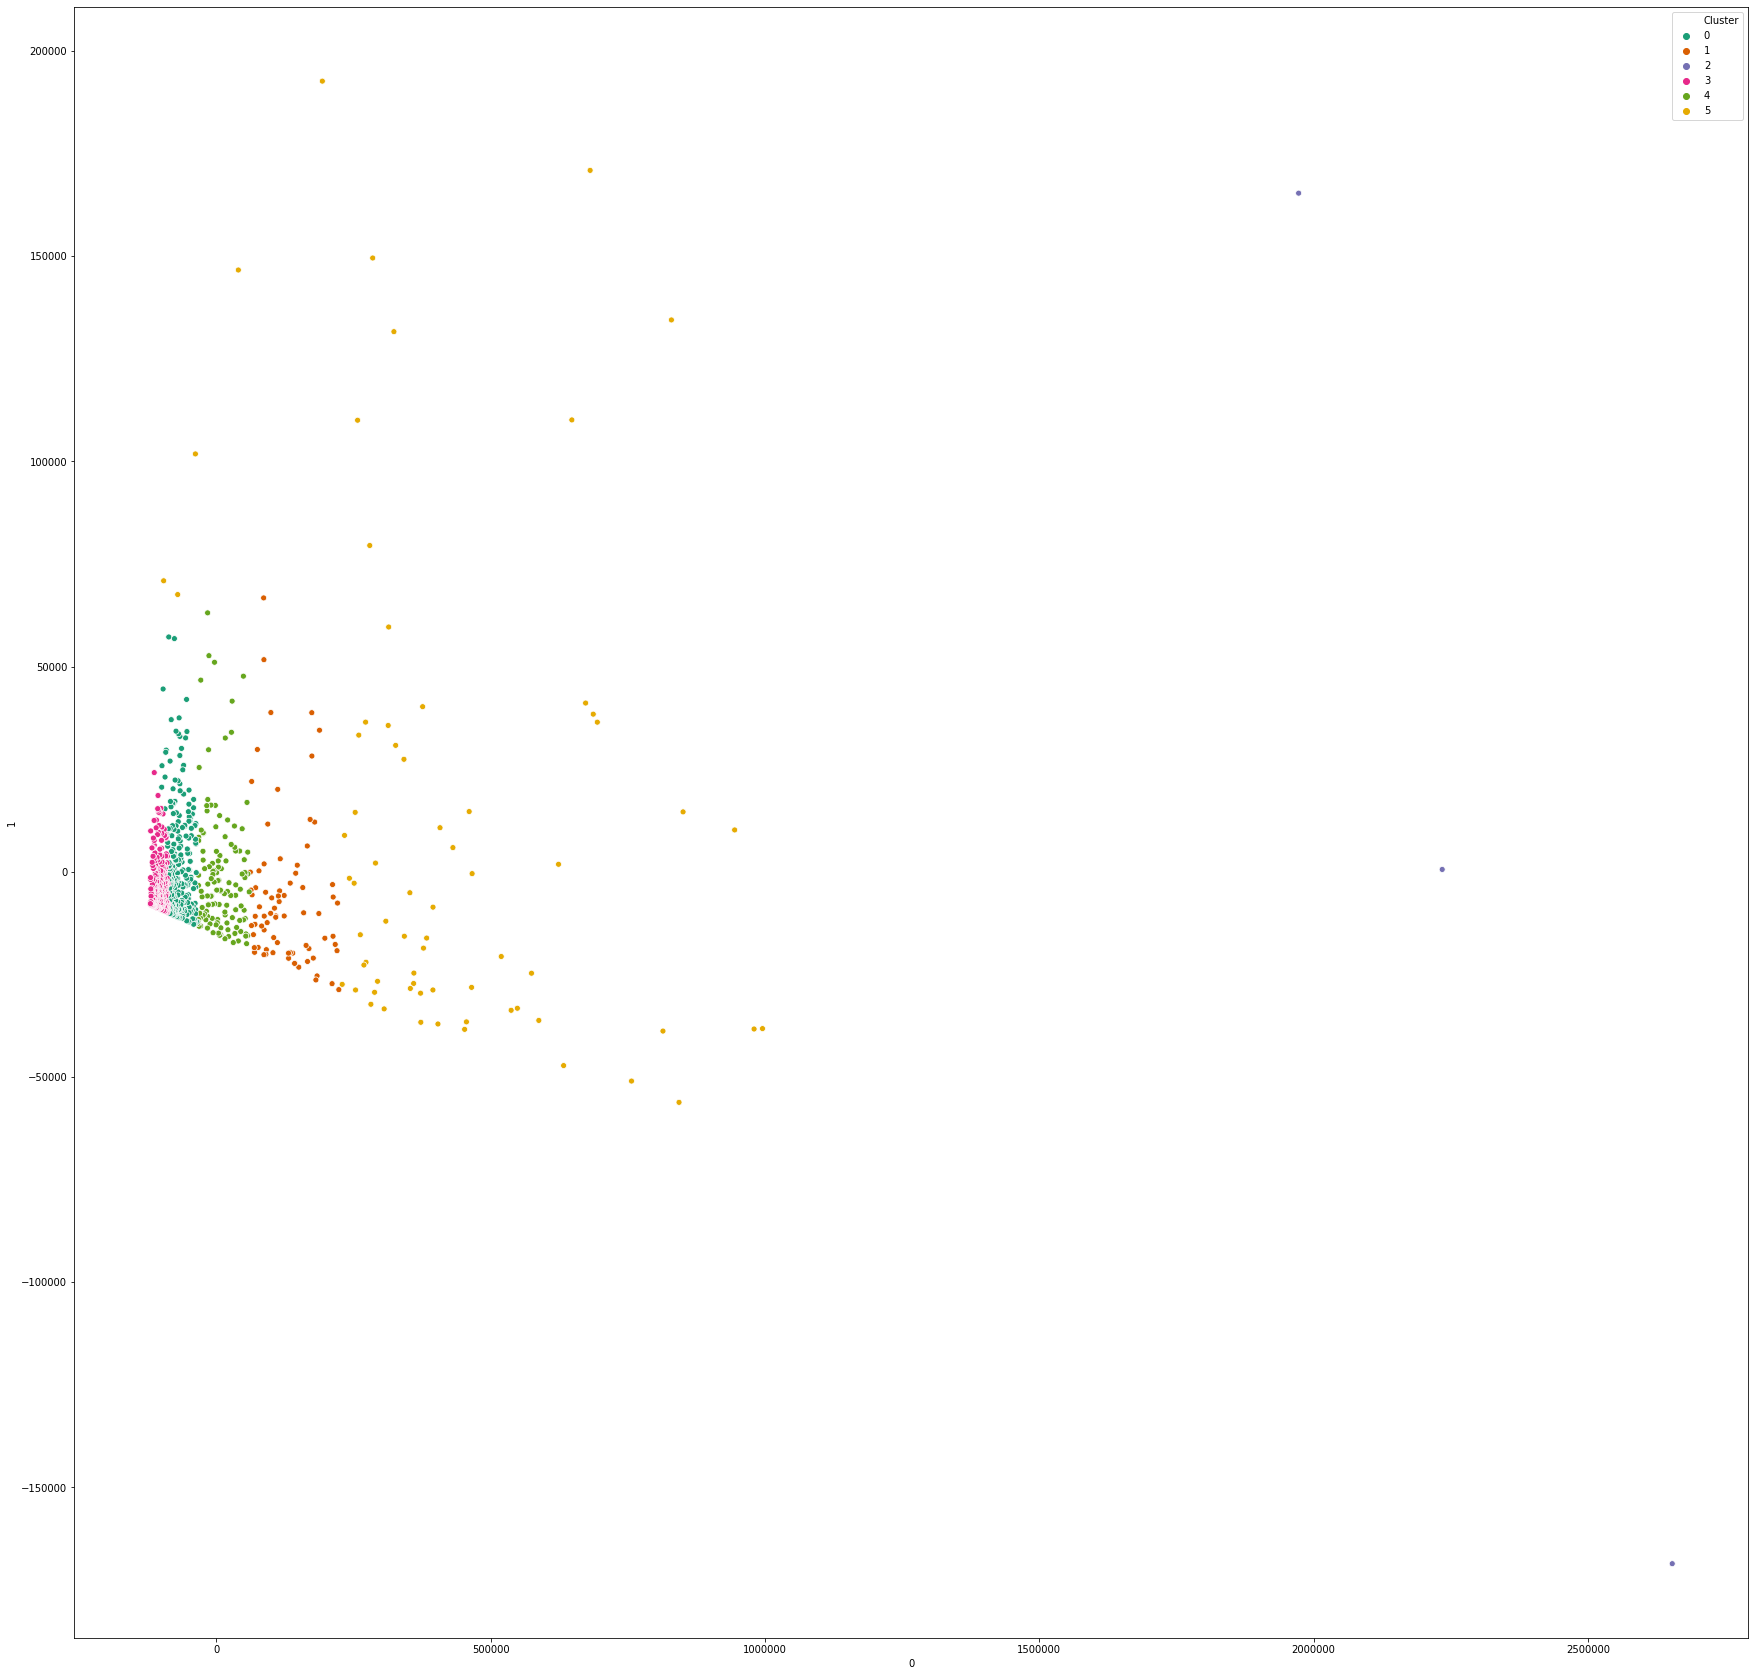

In [56]:
groupby_domains_gm= pd.DataFrame(pca_2_groupby_domains.copy())
groupby_domains_gm['Cluster'] = gm.fit_predict(groupby_domains)
plt.figure(figsize = (30,30))
sns.scatterplot(groupby_domains_gm[0], groupby_domains_gm[1], hue = groupby_domains_gm['Cluster'], palette='Dark2')

In [107]:
pca = PCA (n_components=2)
results = pd.DataFrame(pca.fit_transform(groupby_domains))
results = results.join(groupby_domains_gm['Cluster'])
results.columns = ['Columna1', 'Columna2', 'Cluster']

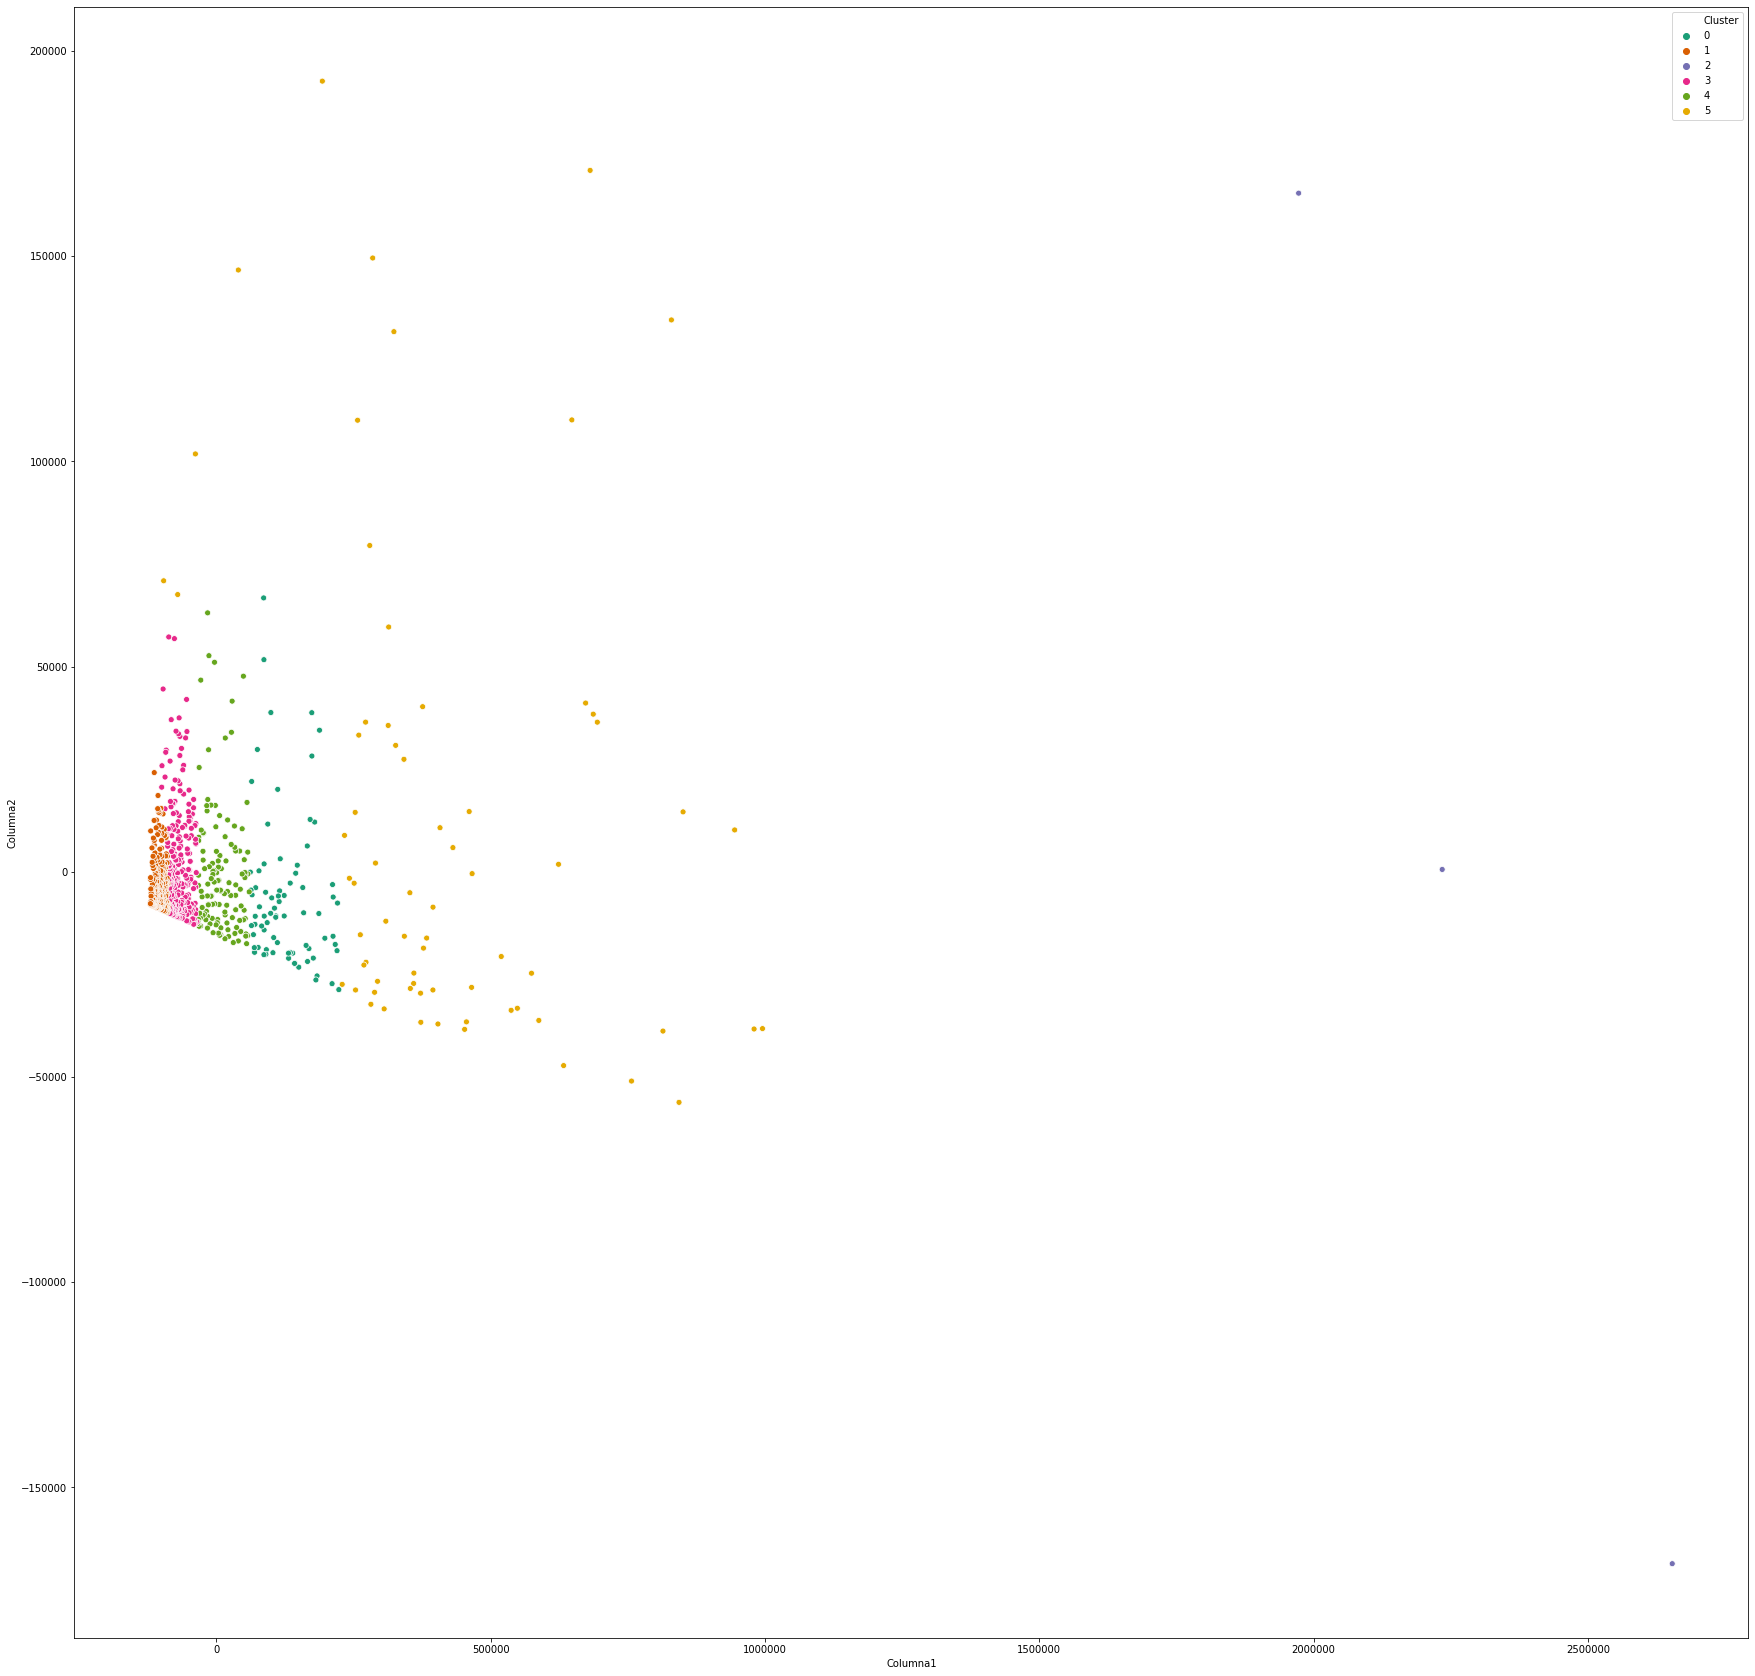

In [110]:
plt.figure(figsize = (30,30))
sns.scatterplot(results['Columna1'], results['Columna2'], hue = results['Cluster'], palette='Dark2')


In [99]:
groupby_domains_gm['Cluster'].value_counts()

1    292
3    248
4    128
0     77
5     70
2      3
Name: Cluster, dtype: int64

In [88]:
pd.DataFrame(gm.predict_proba(groupby_domains))

,0,1,2,3,4,5
0,0.00,0.00,0.00,0.00,1.00,0.00
1,0.00,0.00,0.00,0.00,1.00,0.00
2,0.00,0.00,0.00,0.00,1.00,0.00
3,0.00,0.00,1.00,0.00,0.00,0.00
4,0.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...
813,0.00,1.00,0.00,0.00,0.00,0.00
814,0.00,1.00,0.00,0.00,0.00,0.00
815,0.00,1.00,0.00,0.00,0.00,0.00
816,0.00,1.00,0.00,0.00,0.00,0.00


In [113]:
bg = BayesianGaussianMixture(n_components = 6, covariance_type='spherical')
bg.fit(groupby_domains)

BayesianGaussianMixture(covariance_prior=None, covariance_type='spherical',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=6, n_init=1,
                        random_state=None, reg_covar=1e-06, tol=0.001,
                        verbose=0, verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

In [114]:
pd.DataFrame(bg.fit_predict(groupby_domains))[0].value_counts()

0    394
4    204
5    116
3     73
1     28
2      3
Name: 0, dtype: int64

In [129]:
groupby_domains.shape

(818, 8)

In [135]:
import gower
gower.gower_matrix(groupby_domains)

array([[0.        , 0.22549596, 0.3443053 , ..., 0.32441896, 0.23594625,
        0.33173746],
       [0.22549596, 0.        , 0.16014683, ..., 0.26379904, 0.40729672,
        0.25908333],
       [0.3443053 , 0.16014683, 0.        , ..., 0.3454853 , 0.5172692 ,
        0.32369122],
       ...,
       [0.32441896, 0.26379904, 0.3454853 , ..., 0.        , 0.21201354,
        0.02431212],
       [0.23594625, 0.40729672, 0.5172692 , ..., 0.21201354, 0.        ,
        0.22177179],
       [0.33173746, 0.25908333, 0.32369122, ..., 0.02431212, 0.22177179,
        0.        ]], dtype=float32)

In [120]:
!pip install autoclasswrapper